In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import datetime
import glob
import logic.pulsed.pulse_objects as po

### Attempt at analysis

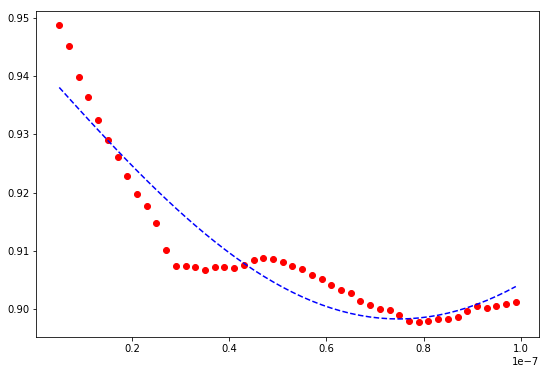

[[Model]]
    ((Model(amplitude_function) * Model(bare_sine_function)) + Model(constant_function))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 48
    # variables        = 4
    chi-square         = 8.9382e-04
    reduced chi-square = 2.0314e-05
    Akaike info crit   = -514.778157
    Bayesian info crit = -507.293353
[[Variables]]
    amplitude:  0.04439844 +/- 0.04413148 (99.40%) (init = 0.03905844)
    frequency:  3339488.21 +/- 2029404.89 (60.77%) (init = 5208333)
    phase:      3.14159265 +/- 0.14562957 (4.64%) (init = 2.225295)
    offset:     0.94270067 +/- 0.04471738 (4.74%) (init = 0.9096402)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, offset)    =  1.000
    C(phase, offset)        = -0.999
    C(amplitude, phase)     = -0.998
    C(frequency, phase)     =  0.998
    C(frequency, offset)    = -0.996
    C(amplitude, frequency) = -0.996
 3.339488212331986 2.9944708183344463e-07


In [45]:
av = []
x = []
locs = sorted(glob.glob('C:/Data/Prime95B/2020/11/20201124/Pulsed/*run_2*'), key=len)
for i,loc in enumerate(locs):
    data = np.load(loc)
#     print(loc)
    a = np.mean(data['data'], axis=(1,2))
    av.append(a[0]/a[1])
    x.append(i)
x = np.arange(5,100,2)*1e-9
y = np.array(av)
plt.plot(x, y, 'ro')

fit = fitlogic.make_sine_fit(x_axis=x[:], data=y[:], estimator=fitlogic.estimate_sine)
plt.plot(x[:], fit.best_fit, 'b--')
plt.show()
print(fit.fit_report(), fit.params['frequency']/1e6, 1/fit.params['frequency'])


In [30]:
def determine_ideal_mw_power(rabi_frequency, p0, v1):
    p1 = p0 - 20*np.log10(rabi_frequency/v1) 
    return round(p1,2)
print(determine_ideal_mw_power(11.7*1e6, -6, 1/(40e-9)))

0.6


In [ ]:
t = np.arange(5,100,2)*1e-9
av = np.array(av)
sp = np.fft.fft(av)/len(av)
sp = sp[range(int(len(av)/2))]
samplingFrequency = len(t)
tpCount     = len(av)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# freq = np.fft.fftfreq(t.shape[-1])
plt.plot(frequencies, abs(sp), 'bo')#, freq, sp.imag)
plt.show()
print(frequencies[0])

# Creating pulse ensemble, uploading, running, collecting images - loop and save

### Create and upload pulse ensemble

In [33]:
def make_rabi_pulse_block(ns, not_ref):
    ele = []
    d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': not_ref, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=ns*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=3e-6, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=500e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=1e-6, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    pulse_block = po.PulseBlock(name=f'auto_rabi_P95B_{ns}_{not_ref}', element_list=ele)
    
    return pulse_block

def make_trigger_cam_block(ms):
    ele = []
    d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=ms*1e-3, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    pulse_block = po.PulseBlock(name=f'trigger_cam_{ms}', element_list=ele)
    
    return pulse_block

def wait_block(ms):
    ele = []
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=ms*1e-3, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    pulse_block = po.PulseBlock(name=f'wait_block_{ms}', element_list=ele)
    
    return pulse_block

### Upload function

In [34]:
def upload_rabi_CW_ensemble(ns, rabi_rep):
    rabi = make_rabi_pulse_block(ns, True)
    rabi_ref = make_rabi_pulse_block(ns, False)
    trigger_cam = make_trigger_cam_block(26)
    wait = wait_block(100)

    created_blocks = [rabi, rabi_ref, trigger_cam, wait]
    for block in created_blocks:
        sequencegeneratorlogic.save_block(block)

    bl = [(trigger_cam.name,1), (rabi.name,rabi_rep), (wait.name,1), (trigger_cam.name,1), (rabi_ref.name,rabi_rep)]
    auto_rabi_CW = po.PulseBlockEnsemble(name='auto_rabi_CW', block_list=bl, rotating_frame=False)

    ensemble = auto_rabi_CW
    ensemblename = auto_rabi_CW.name

    sequencegeneratorlogic.save_ensemble(ensemble)
    sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
    sequencegeneratorlogic.load_ensemble(ensemblename)

### Run pulse and collect image function

In [35]:
def do_cam_CW_pulsed_measure():
    mycamera.ready_pulsed(2)

    pulsedmeasurementlogic.pulse_generator_on()
    mycamlogic.start_trigger_seq(2)
    
    pulsedmeasurementlogic.pulse_generator_off()
    return mycamlogic.get_last_image()

def set_start_MW(power, freq):
    settings = {
    'power': power,
    'frequency': freq,
    'use_ext_microwave': True
    }
    pulsedmeasurementlogic.set_microwave_settings(settings_dict=settings)
    pulsedmeasurementlogic.microwave_on()

### Main function

In [37]:
def main(start, stop, step, n_runs, rabi_rep, power, freq):
    rabi_list = np.arange(start,stop,step)
    size = mycamlogic.get_size()
    set_start_MW(power, freq)
    for ns in tqdm(rabi_list):
        upload_rabi_CW_ensemble(ns, rabi_rep)
        img = np.zeros((2, size[1], size[0]), dtype = np.float64)
        for i in range(n_runs):
            img += do_cam_CW_pulsed_measure()
        img = img/n_runs
        timestamp = datetime.datetime.now()
        t = timestamp.strftime("%Y%m%d-%H%M-%S")
        tag = 'run_3'
        np.savez_compressed(f'C:/Data/Prime95B/2020/11/20201124/Pulsed/{ns}ns_auto_{tag}_{t}', data=img)
    pulsedmeasurementlogic.microwave_off()
    mycamera.pulsed_done()

In [38]:
main(start=20, stop=300, step=2, n_runs=50, rabi_rep=120000, power=-2, freq=2.8625e9)

 64%|##############################################################################################################################7                                                                       | 32/50 [01:41<00:56,  3.16s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:44<01:53,  3.15s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:31<00:06,  3.15s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:29<00:59,  2.97s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:38<01:59,  3.15s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:25<00:12,  3.14s/it]


 56%|##############################################################################################################8                                                                                       | 28/50 [01:29<01:09,  3.16s/it]


 20%|#######################################6                                                                                                                                                              | 10/50 [00:32<02:06,  3.17s/it]


 88%|##############################################################################################################################################################################2                       | 44/50 [02:18<00:18,  3.15s/it]


 52%|######################################################################################################9                                                                                               | 26/50 [01:18<01:11,  2.97s/it]


 16%|###############################8                                                                                                                                                                       | 8/50 [00:26<02:15,  3.23s/it]


 84%|######################################################################################################################################################################3                               | 42/50 [02:13<00:25,  3.14s/it]


 48%|###############################################################################################                                                                                                       | 24/50 [01:16<01:22,  3.16s/it]


 12%|#######################8                                                                                                                                                                               | 6/50 [00:19<02:26,  3.32s/it]


 80%|##############################################################################################################################################################4                                       | 40/50 [02:07<00:31,  3.15s/it]


 44%|#######################################################################################1                                                                                                              | 22/50 [01:06<01:23,  2.99s/it]


  8%|###############9                                                                                                                                                                                       | 4/50 [00:13<02:36,  3.40s/it]


 76%|######################################################################################################################################################4                                               | 38/50 [02:00<00:37,  3.16s/it]


 40%|###############################################################################2                                                                                                                      | 20/50 [01:06<01:35,  3.19s/it]


  4%|#######9                                                                                                                                                                                               | 2/50 [00:06<02:53,  3.61s/it]


 72%|##############################################################################################################################################5                                                       | 36/50 [01:54<00:44,  3.16s/it]


 36%|#######################################################################2                                                                                                                              | 18/50 [00:54<01:35,  3.00s/it]


  0%|                                                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]


 68%|######################################################################################################################################6                                                               | 34/50 [01:48<00:50,  3.16s/it]


 32%|###############################################################3                                                                                                                                      | 16/50 [00:51<01:48,  3.20s/it]


100%|######################################################################################################################################################################################################| 50/50 [02:40<00:00,  3.20s/it]


 64%|##############################################################################################################################7                                                                       | 32/50 [01:41<00:56,  3.16s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:42<01:47,  3.00s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:24<00:05,  2.99s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:35<01:03,  3.16s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:38<02:01,  3.19s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:27<00:12,  3.18s/it]


 56%|##############################################################################################################8                                                                                       | 28/50 [01:29<01:09,  3.17s/it]


 20%|#######################################6                                                                                                                                                              | 10/50 [00:30<02:00,  3.02s/it]


 88%|##############################################################################################################################################################################2                       | 44/50 [02:12<00:17,  2.99s/it]


 52%|######################################################################################################9                                                                                               | 26/50 [01:23<01:15,  3.17s/it]


 16%|###############################8                                                                                                                                                                       | 8/50 [00:26<02:15,  3.23s/it]


 84%|######################################################################################################################################################################3                               | 42/50 [02:14<00:25,  3.18s/it]


 48%|###############################################################################################                                                                                                       | 24/50 [01:16<01:22,  3.16s/it]


 12%|#######################8                                                                                                                                                                               | 6/50 [00:18<02:16,  3.10s/it]


 80%|##############################################################################################################################################################4                                       | 40/50 [02:00<00:29,  2.99s/it]


 44%|#######################################################################################1                                                                                                              | 22/50 [01:10<01:28,  3.16s/it]


  8%|###############9                                                                                                                                                                                       | 4/50 [00:17<03:40,  4.79s/it]


 76%|######################################################################################################################################################4                                               | 38/50 [02:05<00:38,  3.18s/it]


 40%|###############################################################################2                                                                                                                      | 20/50 [01:03<01:34,  3.17s/it]


  4%|#######9                                                                                                                                                                                               | 2/50 [00:06<02:45,  3.45s/it]


 72%|##############################################################################################################################################5                                                       | 36/50 [01:48<00:41,  3.00s/it]


 36%|#######################################################################2                                                                                                                              | 18/50 [00:57<01:41,  3.18s/it]


  0%|                                                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]


 68%|######################################################################################################################################6                                                               | 34/50 [01:48<00:50,  3.18s/it]


 32%|###############################################################3                                                                                                                                      | 16/50 [00:51<01:47,  3.17s/it]


100%|######################################################################################################################################################################################################| 50/50 [02:38<00:00,  3.18s/it]


 64%|##############################################################################################################################7                                                                       | 32/50 [01:36<00:53,  3.00s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:44<01:54,  3.18s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:32<00:06,  3.17s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:36<01:03,  3.18s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:38<02:00,  3.18s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:26<00:12,  3.17s/it]


 56%|##############################################################################################################8                                                                                       | 28/50 [01:24<01:06,  3.01s/it]


 20%|#######################################6                                                                                                                                                              | 10/50 [00:32<02:07,  3.19s/it]


 88%|##############################################################################################################################################################################2                       | 44/50 [02:20<00:18,  3.17s/it]


 52%|######################################################################################################9                                                                                               | 26/50 [01:23<01:16,  3.18s/it]


 16%|###############################8                                                                                                                                                                       | 8/50 [00:27<02:19,  3.32s/it]


 84%|######################################################################################################################################################################3                               | 42/50 [02:15<00:25,  3.17s/it]


 48%|###############################################################################################                                                                                                       | 24/50 [01:12<01:17,  3.00s/it]


 12%|#######################8                                                                                                                                                                               | 6/50 [00:19<02:24,  3.29s/it]


 80%|##############################################################################################################################################################4                                       | 40/50 [02:07<00:31,  3.17s/it]


 44%|#######################################################################################1                                                                                                              | 22/50 [01:10<01:29,  3.18s/it]


  8%|###############9                                                                                                                                                                                       | 4/50 [00:13<02:40,  3.49s/it]


 76%|######################################################################################################################################################4                                               | 38/50 [02:01<00:37,  3.16s/it]


 40%|###############################################################################2                                                                                                                      | 20/50 [01:00<01:29,  3.00s/it]


  4%|#######9                                                                                                                                                                                               | 2/50 [00:06<02:53,  3.62s/it]


 72%|##############################################################################################################################################5                                                       | 36/50 [01:54<00:44,  3.17s/it]


 36%|#######################################################################2                                                                                                                              | 18/50 [00:57<01:41,  3.18s/it]


  0%|                                                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]


 68%|######################################################################################################################################6                                                               | 34/50 [01:48<00:50,  3.17s/it]


 32%|###############################################################3                                                                                                                                      | 16/50 [00:48<01:41,  3.00s/it]


100%|######################################################################################################################################################################################################| 50/50 [02:30<00:00,  3.01s/it]


 64%|##############################################################################################################################7                                                                       | 32/50 [01:42<00:56,  3.16s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:45<01:54,  3.19s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:33<00:06,  3.18s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:35<01:03,  3.17s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:36<01:55,  3.03s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:19<00:12,  3.02s/it]


 56%|##############################################################################################################8                                                                                       | 28/50 [01:29<01:10,  3.19s/it]


 20%|#######################################6                                                                                                                                                              | 10/50 [00:36<02:15,  3.38s/it]


 88%|##############################################################################################################################################################################2                       | 44/50 [02:25<00:19,  3.20s/it]


 52%|######################################################################################################9                                                                                               | 26/50 [01:23<01:16,  3.19s/it]


 16%|###############################8                                                                                                                                                                       | 8/50 [00:24<02:08,  3.07s/it]


 84%|######################################################################################################################################################################3                               | 42/50 [02:07<00:24,  3.02s/it]


 48%|###############################################################################################                                                                                                       | 24/50 [01:17<01:22,  3.19s/it]


 12%|#######################8                                                                                                                                                                               | 6/50 [00:19<02:25,  3.31s/it]


 80%|##############################################################################################################################################################4                                       | 40/50 [02:08<00:32,  3.20s/it]


 44%|#######################################################################################1                                                                                                              | 22/50 [01:10<01:29,  3.19s/it]


  8%|###############9                                                                                                                                                                                       | 4/50 [00:12<02:29,  3.25s/it]


 76%|######################################################################################################################################################4                                               | 38/50 [01:56<00:36,  3.02s/it]


 40%|###############################################################################2                                                                                                                      | 20/50 [01:04<01:35,  3.18s/it]


  4%|#######9                                                                                                                                                                                               | 2/50 [00:07<02:55,  3.66s/it]


 72%|##############################################################################################################################################5                                                       | 36/50 [01:56<00:44,  3.21s/it]


 36%|#######################################################################2                                                                                                                              | 18/50 [00:58<01:41,  3.19s/it]


  0%|                                                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]


 68%|######################################################################################################################################6                                                               | 34/50 [01:43<00:48,  3.02s/it]


 32%|###############################################################3                                                                                                                                      | 16/50 [00:51<01:48,  3.19s/it]


100%|######################################################################################################################################################################################################| 50/50 [02:40<00:00,  3.20s/it]


 64%|##############################################################################################################################7                                                                       | 32/50 [01:43<00:57,  3.20s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:45<01:55,  3.21s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:33<00:06,  3.19s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:31<01:00,  3.02s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:38<02:01,  3.20s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:27<00:12,  3.19s/it]


 56%|##############################################################################################################8                                                                                       | 28/50 [01:30<01:10,  3.20s/it]


 20%|#######################################6                                                                                                                                                              | 10/50 [00:32<02:08,  3.21s/it]


 88%|##############################################################################################################################################################################2                       | 44/50 [02:20<00:19,  3.19s/it]


 52%|######################################################################################################9                                                                                               | 26/50 [01:19<01:12,  3.02s/it]


 16%|###############################8                                                                                                                                                                       | 8/50 [00:26<02:16,  3.25s/it]


 84%|######################################################################################################################################################################3                               | 42/50 [02:14<00:25,  3.19s/it]


 48%|###############################################################################################                                                                                                       | 24/50 [01:17<01:23,  3.20s/it]


 12%|#######################8                                                                                                                                                                               | 6/50 [00:19<02:25,  3.30s/it]


 80%|##############################################################################################################################################################4                                       | 40/50 [02:08<00:31,  3.18s/it]


 44%|#######################################################################################1                                                                                                              | 22/50 [01:07<01:24,  3.02s/it]


  8%|###############9                                                                                                                                                                                       | 4/50 [00:13<02:39,  3.46s/it]


 76%|######################################################################################################################################################4                                               | 38/50 [02:01<00:38,  3.19s/it]


 40%|###############################################################################2                                                                                                                      | 20/50 [01:08<01:36,  3.21s/it]


  4%|#######9                                                                                                                                                                                               | 2/50 [00:07<02:55,  3.66s/it]


 72%|##############################################################################################################################################5                                                       | 36/50 [01:55<00:44,  3.19s/it]


 36%|#######################################################################2                                                                                                                              | 18/50 [00:57<01:36,  3.02s/it]


  0%|                                                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]


 68%|######################################################################################################################################6                                                               | 34/50 [01:48<00:50,  3.19s/it]


 32%|###############################################################3                                                                                                                                      | 16/50 [00:52<01:49,  3.21s/it]


100%|######################################################################################################################################################################################################| 50/50 [02:41<00:00,  3.22s/it]


 64%|##############################################################################################################################7                                                                       | 32/50 [01:42<00:57,  3.18s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:42<01:48,  3.02s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:25<00:06,  3.02s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:36<01:03,  3.19s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:39<02:02,  3.22s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:28<00:12,  3.20s/it]


 56%|##############################################################################################################8                                                                                       | 28/50 [01:29<01:10,  3.19s/it]


 20%|#######################################6                                                                                                                                                              | 10/50 [00:30<02:01,  3.04s/it]


 88%|##############################################################################################################################################################################2                       | 44/50 [02:13<00:18,  3.02s/it]


 52%|######################################################################################################9                                                                                               | 26/50 [01:23<01:16,  3.19s/it]


 16%|###############################8                                                                                                                                                                       | 8/50 [00:26<02:16,  3.26s/it]


 84%|######################################################################################################################################################################3                               | 42/50 [02:15<00:25,  3.20s/it]


 48%|###############################################################################################                                                                                                       | 24/50 [01:17<01:22,  3.19s/it]


 12%|#######################8                                                                                                                                                                               | 6/50 [00:18<02:18,  3.15s/it]


 80%|##############################################################################################################################################################4                                       | 40/50 [02:01<00:30,  3.02s/it]


 44%|#######################################################################################1                                                                                                              | 22/50 [01:11<01:29,  3.20s/it]


  8%|###############9                                                                                                                                                                                       | 4/50 [00:13<02:37,  3.42s/it]


 76%|######################################################################################################################################################4                                               | 38/50 [02:02<00:38,  3.21s/it]


 40%|###############################################################################2                                                                                                                      | 20/50 [01:04<01:35,  3.20s/it]


  4%|#######9                                                                                                                                                                                               | 2/50 [00:06<02:47,  3.48s/it]


 72%|##############################################################################################################################################5                                                       | 36/50 [01:50<00:42,  3.05s/it]


 36%|#######################################################################2                                                                                                                              | 18/50 [00:58<01:42,  3.21s/it]


  0%|                                                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]


 68%|######################################################################################################################################6                                                               | 34/50 [01:50<00:51,  3.22s/it]


 32%|###############################################################3                                                                                                                                      | 16/50 [00:51<01:49,  3.21s/it]


100%|######################################################################################################################################################################################################| 50/50 [02:40<00:00,  3.22s/it]


 64%|##############################################################################################################################7                                                                       | 32/50 [01:37<00:54,  3.04s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:46<01:55,  3.22s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:35<00:06,  3.21s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:37<01:04,  3.22s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:39<02:02,  3.22s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:28<00:12,  3.21s/it]


 56%|##############################################################################################################8                                                                                       | 28/50 [01:25<01:06,  3.04s/it]


 20%|#######################################6                                                                                                                                                              | 10/50 [00:36<02:15,  3.39s/it]


 88%|##############################################################################################################################################################################2                       | 44/50 [02:25<00:19,  3.21s/it]


 52%|######################################################################################################9                                                                                               | 26/50 [01:24<01:17,  3.22s/it]


 16%|###############################8                                                                                                                                                                       | 8/50 [00:26<02:16,  3.26s/it]


 84%|######################################################################################################################################################################3                               | 42/50 [02:15<00:25,  3.21s/it]


 48%|###############################################################################################                                                                                                       | 24/50 [01:14<01:18,  3.04s/it]


 12%|#######################8                                                                                                                                                                               | 6/50 [00:19<02:26,  3.32s/it]


 80%|##############################################################################################################################################################4                                       | 40/50 [02:08<00:32,  3.21s/it]


 44%|#######################################################################################1                                                                                                              | 22/50 [01:11<01:30,  3.22s/it]


  8%|###############9                                                                                                                                                                                       | 4/50 [00:18<04:01,  5.24s/it]


 76%|######################################################################################################################################################4                                               | 38/50 [02:07<00:38,  3.21s/it]


 40%|###############################################################################2                                                                                                                      | 20/50 [01:01<01:31,  3.04s/it]


  4%|#######9                                                                                                                                                                                               | 2/50 [00:07<02:57,  3.69s/it]


 72%|##############################################################################################################################################5                                                       | 36/50 [01:56<00:44,  3.21s/it]


 36%|#######################################################################2                                                                                                                              | 18/50 [00:58<01:43,  3.22s/it]


  0%|                                                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]


 68%|######################################################################################################################################6                                                               | 34/50 [01:49<00:51,  3.21s/it]


 32%|###############################################################3                                                                                                                                      | 16/50 [00:49<01:43,  3.04s/it]


100%|######################################################################################################################################################################################################| 50/50 [02:34<00:00,  3.08s/it]


 64%|##############################################################################################################################7                                                                       | 32/50 [01:43<00:57,  3.21s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:45<01:56,  3.23s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:35<00:06,  3.22s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:36<01:04,  3.21s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:37<01:56,  3.05s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:20<00:12,  3.04s/it]


 56%|##############################################################################################################8                                                                                       | 28/50 [01:30<01:11,  3.26s/it]


 20%|#######################################6                                                                                                                                                              | 10/50 [00:32<02:10,  3.25s/it]


 88%|##############################################################################################################################################################################2                       | 44/50 [02:22<00:19,  3.22s/it]


 52%|######################################################################################################9                                                                                               | 26/50 [01:24<01:17,  3.21s/it]


 16%|###############################8                                                                                                                                                                       | 8/50 [00:25<02:10,  3.10s/it]


 84%|######################################################################################################################################################################3                               | 42/50 [02:08<00:24,  3.04s/it]


 48%|###############################################################################################                                                                                                       | 24/50 [01:17<01:23,  3.21s/it]


 12%|#######################8                                                                                                                                                                               | 6/50 [00:19<02:26,  3.33s/it]


 80%|##############################################################################################################################################################4                                       | 40/50 [02:09<00:32,  3.22s/it]


 44%|#######################################################################################1                                                                                                              | 22/50 [01:11<01:29,  3.21s/it]


  8%|###############9                                                                                                                                                                                       | 4/50 [00:12<02:30,  3.26s/it]


 76%|######################################################################################################################################################4                                               | 38/50 [01:56<00:36,  3.04s/it]


 40%|###############################################################################2                                                                                                                      | 20/50 [01:04<01:36,  3.21s/it]


  4%|#######9                                                                                                                                                                                               | 2/50 [00:07<02:58,  3.72s/it]


 72%|##############################################################################################################################################5                                                       | 36/50 [01:56<00:45,  3.22s/it]


 36%|#######################################################################2                                                                                                                              | 18/50 [00:58<01:42,  3.21s/it]


  0%|                                                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]


 68%|######################################################################################################################################6                                                               | 34/50 [01:47<00:48,  3.04s/it]


 32%|###############################################################3                                                                                                                                      | 16/50 [00:52<01:49,  3.21s/it]


100%|######################################################################################################################################################################################################| 50/50 [02:41<00:00,  3.22s/it]


 64%|##############################################################################################################################7                                                                       | 32/50 [01:43<00:58,  3.22s/it]


 28%|#######################################################4                                                                                                                                              | 14/50 [00:45<01:55,  3.21s/it]


 96%|##############################################################################################################################################################################################        | 48/50 [02:34<00:06,  3.21s/it]


 60%|######################################################################################################################8                                                                               | 30/50 [01:31<01:00,  3.04s/it]


 24%|###############################################5                                                                                                                                                      | 12/50 [00:40<02:03,  3.24s/it]


 92%|######################################################################################################################################################################################1               | 46/50 [02:29<00:12,  3.25s/it]


100%|#################################################################################################################################################################################################| 140/140 [8:13:31<00:00, 211.51s/it]
